In [470]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import time


In [471]:
def load_calibration(file):
    """
    Parse calibration file containing camera intrinsics and stereo parameters.
    
    Args:
        file: Path to calibration file
        
    Returns:
        dict: Dictionary containing:
            - cam0: 3x3 numpy array (left camera intrinsic matrix)
            - cam1: 3x3 numpy array (right camera intrinsic matrix)
            - doffs: float (disparity offset)
            - baseline: float (stereo baseline in mm)
            - width: int (image width)
            - height: int (image height)
            - ndisp: int (number of disparities)
    """
    calib = {}
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            key, value = line.split('=')
            
            if key in ['cam0', 'cam1']:
                matrix_str = value.strip('[]')
                rows = matrix_str.split(';')
                matrix = []
                for row in rows:
                    matrix.append([float(x) for x in row.split()])
                calib[key] = np.array(matrix)
            elif key in ['width', 'height', 'ndisp']:
                calib[key] = int(value)
            else:  # doffs, baseline
                calib[key] = float(value)
    
    return calib

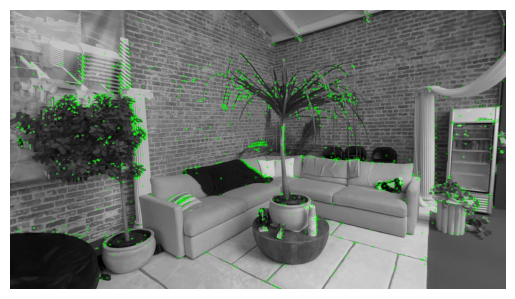

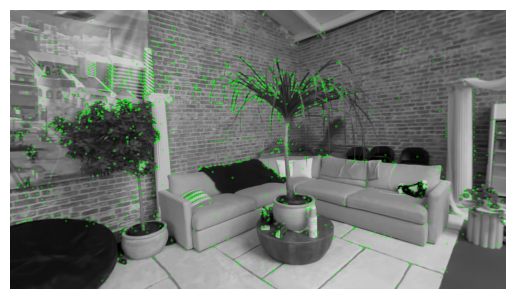

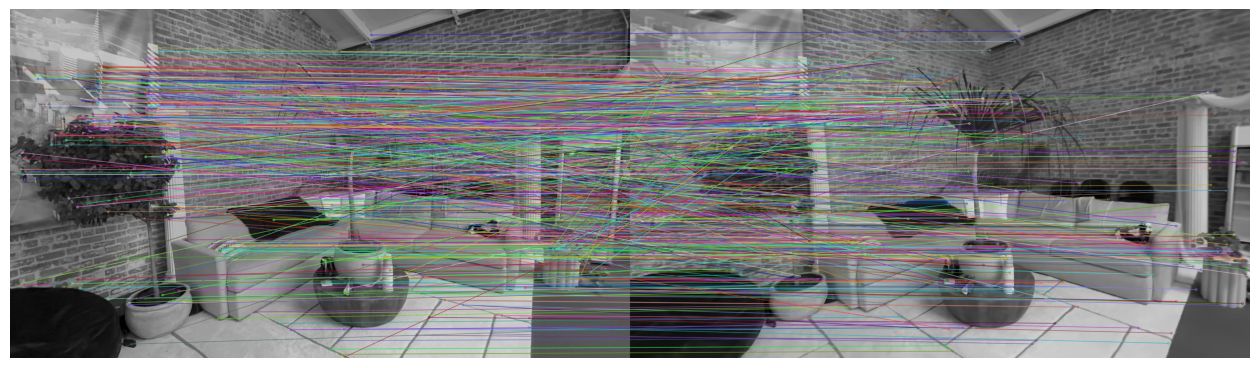

In [ ]:
imgs = ['data/two-view/exa2/im0.png','data/two-view/exa2/im3.png']
calib = load_calibration('data/two-view/exa2/calib.txt')

img0 = cv2.imread(imgs[0], cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(imgs[1], cv2.IMREAD_GRAYSCALE)

# grayscale image
# feature detection + description
# feature matching
# two view geometry with RANSAC


# Initiate ORB detector
orb = cv2.SIFT.create(2000)
kp0,des0 = orb.detectAndCompute(img0, None)
kp1,des1 = orb.detectAndCompute(img1, None)

ro = cv2.drawKeypoints(img0, kp0, None, color=(0,255,0), flags=0)
r1 = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)

plt.axis('off'); plt.imshow(ro), plt.show()
plt.axis('off'); plt.imshow(r1), plt.show()

bf = cv2.BFMatcher(cv2.NORM_L2

In [ ]:
, crossCheck=True)
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x: x.distance)

img2 = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(16, 10)); ax.axis('off'); ax.imshow(img2); plt.show()

In [473]:
def evaluate_reprojection(projection_c0_to_c1, points3d_homogeneous, p0, p1):
    """
    Evaluate reprojection error: compute average distance between observed and reprojected points.
    
    Args:
        projection_c0_to_c1: 3x4 projection matrix
        points3d_homogeneous: 4xN array of homogeneous 3D points
        p0: Nx2 array of normalized image points from camera 0
        p1: Nx2 array of normalized image points from camera 1
    
    Returns:
        float: Average reprojection error in normalized coordinates
    """
    assert projection_c0_to_c1.shape == (3, 4)
    assert points3d_homogeneous.shape[0] == 4
    assert p0.shape[0] == p1.shape[0]
    assert p0.shape[1] == 2
    assert p1.shape[1] == 2
    
    # Convert homogeneous to 3D coordinates
    points3d = points3d_homogeneous[:3] / points3d_homogeneous[3]
    
    # Reproject to camera 1 (identity projection)
    p1_reproj = points3d[:2, :].T / points3d[2:3, :].T
    
    # Reproject to camera 2
    R = projection_c0_to_c1[:3, :3]
    t = projection_c0_to_c1[:3, 3:4]
    points3d_c2 = (R @ points3d + t)
    p2_reproj = points3d_c2[:2, :].T / points3d_c2[2:3, :].T
    
    # Compute reprojection errors
    error1 = np.linalg.norm(p0 - p1_reproj, axis=1)
    error2 = np.linalg.norm(p1 - p2_reproj, axis=1)
    
    # Return average error
    return np.mean(error1 + error2)


from cv2 import UMat
k0 = UMat(calib['cam0'])
k1 = UMat(calib['cam1'])

print(calib)
points1 = np.array([kp0[m.queryIdx].pt for m in matches])
points2 = np.array([kp1[m.trainIdx].pt for m in matches])
(cam0_cx, cam0_cy, cam0_fx, cam0_fy) = calib['cam0'][0][2], calib['cam0'][1][2], calib['cam0'][0][0], calib['cam0'][1][1]
(cam1_cx, cam1_cy, cam1_fx, cam1_fy) = calib['cam1'][0][2], calib['cam1'][1][2], calib['cam1'][0][0], calib['cam1'][1][1]
points1_norm = [(x[0] - cam0_cx / cam0_fx, x[1] - cam0_cy / cam0_fy) for x in points1]
points2_norm = [(x[0] - cam1_cx / cam1_fx, x[1] - cam1_cy / cam1_fy) for x in points2]

[es, mask] = cv2.findEssentialMat(
  points1=points1,
  points2=points2, 
  cameraMatrix=k0, 
  # method=cv2.LMEDS,
  method=cv2.RANSAC,
)

# Apply the RANSAC inlier mask
mask_essential = mask.get().ravel().astype(bool)
print(f"RANSAC inliers: {np.sum(mask_essential)}/{len(mask_essential)} ({100*np.sum(mask_essential)/len(mask_essential):.1f}%)")
points1_inliers = points1[mask_essential]
points2_inliers = points2[mask_essential]


retval, R, t, mask_pose = cv2.recoverPose(es, points1_inliers, points2_inliers, cameraMatrix=k0)
t = np.multiply(t.get().reshape(-1), 10.0).reshape(3,1)
# t = t.get()

projection_w_to_c0 = np.identity(4)[:3]
projection_c0_to_c1 = np.hstack((R.get(), t))
# triangulate points
points_c0 = cv2.triangulatePoints(projection_w_to_c0, projection_c0_to_c1, points1_inliers.T, points2_inliers.T)
print(R.get().shape, points_c0.shape, t.shape)
points_c0 = points_c0[:3] / points_c0[3]
print(R.get().shape, points_c0.shape, t.shape)
points_c1 = R.get() @ points_c0 + t


{'cam0': array([[840.164,   0.   , 640.   ],
       [  0.   , 840.164, 360.   ],
       [  0.   ,   0.   ,   1.   ]]), 'cam1': array([[840.164,   0.   , 640.   ],
       [  0.   , 840.164, 360.   ],
       [  0.   ,   0.   ,   1.   ]]), 'doffs': 0.0, 'width': 1280, 'height': 720, 'ndisp': 942}
RANSAC inliers: 166/700 (23.7%)
(3, 3) (4, 166) (3, 1)
(3, 3) (3, 166) (3, 1)


(3, 3) (3, 1)
[[-7.98764101]
 [ 0.19603997]
 [ 6.01324866]]


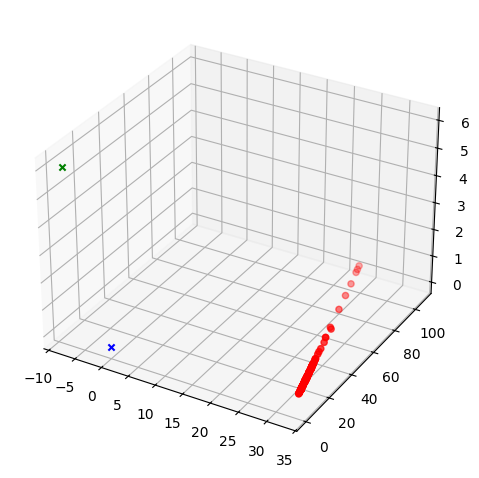

In [474]:
# world plot + camera position

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_c0[0], points_c0[1], points_c0[2], c='r', marker='o')
#c0
ax.scatter(0, 0, 0, c='b', marker='x')
#c1 pose
print(R.get().shape, t.shape)
c1_pose = R.get() @ np.array([[0,0,0]]).T + t
print(c1_pose)
ax.scatter(c1_pose[0], c1_pose[1], c1_pose[2], c='g', marker='x')

plt.tight_layout()
plt.show()



Number of triangulated points: 166
Points 3D shape: (3, 166)


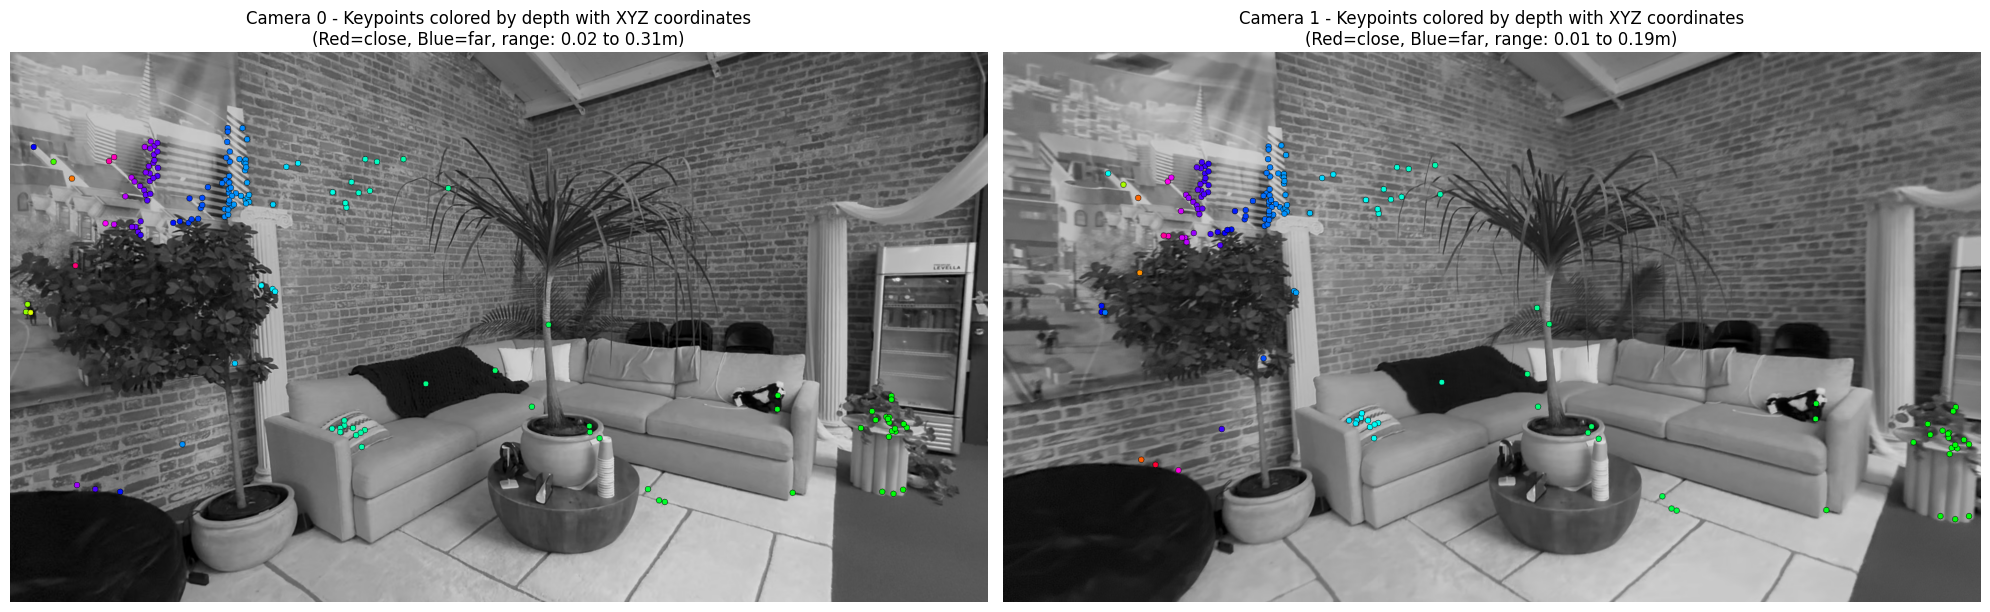

Camera 0 depth statistics:
  Min: 0.018m
  Max: 0.306m
  Mean: 0.072m
  Median: 0.069m

Camera 1 depth statistics:
  Min: 0.013m
  Max: 0.195m
  Mean: 0.050m
  Median: 0.047m


In [475]:
def drawKeypointsWithDepth(image, keypoints, points3d, radius=5, show_coords=False, font_scale=0.35):
    """
    Draw keypoints colored by their triangulated depth, with optional 3D coordinates.
    
    Args:
        image: Input grayscale or color image
        keypoints: List of cv2.KeyPoint objects to draw
        points3d: 3xN array of 3D points (X, Y, Z coordinates)
        radius: Radius of circles to draw (default: 5)
        show_coords: Whether to display XYZ coordinates (default: True)
        font_scale: Font scale for coordinate text (default: 0.35)
    
    Returns:
        Image with keypoints drawn, colored by depth (red=near, blue=far)
    """
    # Convert grayscale to BGR if needed
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output = image.copy()
    
    # Extract depths (Z coordinates)
    depths = points3d[2]
    
    # Normalize depths to 0-1 range for color mapping
    depth_min = np.min(depths)
    depth_max = np.max(depths)
    depths_normalized = (depths - depth_min) / (depth_max - depth_min)
    
    # Draw each keypoint with depth-based color
    for i, (kp, depth_norm) in enumerate(zip(keypoints, depths_normalized)):
        # Color map: red (close) -> yellow -> green -> cyan -> blue (far)
        # Using HSV colormap: hue goes from 0 (red) to 240 (blue)
        hue = int((1.0 - depth_norm) * 240)  # Invert so red=close, blue=far
        color_hsv = np.uint8([[[hue, 255, 255]]])
        color_bgr = cv2.cvtColor(color_hsv, cv2.COLOR_HSV2BGR)[0][0]
        color = (int(color_bgr[0]), int(color_bgr[1]), int(color_bgr[2]))
        
        # Draw the keypoint as a filled circle
        pt = (int(kp.pt[0]), int(kp.pt[1]))
        cv2.circle(output, pt, radius, color, -1)
        cv2.circle(output, pt, radius, (0, 0, 0), 1)  # Black outline
        
        # Add XYZ coordinates as text
        if show_coords:
            x, y, z = points3d[0, i], points3d[1, i], points3d[2, i]
            text = f"({x:.2f},{y:.2f},{z:.2f})"
            
            # Position text offset from the keypoint
            text_pos = (pt[0] + radius + 3, pt[1])
            
            # Draw text with black background for readability
            font = cv2.FONT_HERSHEY_SIMPLEX
            thickness = 1
            
            # Get text size for background
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
            
            # Draw semi-transparent background
            overlay = output.copy()
            cv2.rectangle(overlay, 
                         (text_pos[0] - 2, text_pos[1] - text_height - 2),
                         (text_pos[0] + text_width + 2, text_pos[1] + baseline + 2),
                         (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.6, output, 0.4, 0, output)
            
            # Draw text
            cv2.putText(output, text, text_pos, font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)
    
    return output


# Get the inlier keypoints that correspond to triangulated points
# Need to map from inlier indices back to keypoint objects
matches_inliers = [matches[i] for i, m in enumerate(mask_essential) if m]
kp0_inliers = [kp0[m.queryIdx] for m in matches_inliers]
kp1_inliers = [kp1[m.trainIdx] for m in matches_inliers]

print(f"Number of triangulated points: {len(kp0_inliers)}")
print(f"Points 3D shape: {points_c0.shape}")

# Draw keypoints with depth coloring and XYZ coordinates
img0_depth = drawKeypointsWithDepth(img0, kp0_inliers, points_c0, radius=6, show_coords=False, font_scale=0.6)
img1_depth = drawKeypointsWithDepth(img1, kp1_inliers, points_c1, radius=6, show_coords=False, font_scale=0.6)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].imshow(img0_depth)
axes[0].set_title(f'Camera 0 - Keypoints colored by depth with XYZ coordinates\n(Red=close, Blue=far, range: {points_c0[2].min():.2f} to {points_c0[2].max():.2f}m)')
axes[0].axis('off')

axes[1].imshow(img1_depth)
axes[1].set_title(f'Camera 1 - Keypoints colored by depth with XYZ coordinates\n(Red=close, Blue=far, range: {points_c1[2].min():.2f} to {points_c1[2].max():.2f}m)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print depth statistics
print(f"Camera 0 depth statistics:")
print(f"  Min: {points_c0[2].min():.3f}m")
print(f"  Max: {points_c0[2].max():.3f}m")
print(f"  Mean: {points_c0[2].mean():.3f}m")
print(f"  Median: {np.median(points_c0[2]):.3f}m")
print(f"\nCamera 1 depth statistics:")
print(f"  Min: {points_c1[2].min():.3f}m")
print(f"  Max: {points_c1[2].max():.3f}m")
print(f"  Mean: {points_c1[2].mean():.3f}m")
print(f"  Median: {np.median(points_c1[2]):.3f}m")


In [476]:
def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    """
    Convert quaternion to 3x3 rotation matrix.
    Uses the standard quaternion to rotation matrix formula.
    
    Args:
        qw, qx, qy, qz: Quaternion components (scalar-first convention)
    
    Returns:
        3x3 numpy rotation matrix
    """
    # Normalize quaternion
    norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
    qw, qx, qy, qz = qw/norm, qx/norm, qy/norm, qz/norm
    
    # Compute rotation matrix
    R = np.array([
        [1 - 2*(qy**2 + qz**2), 2*(qx*qy - qw*qz), 2*(qx*qz + qw*qy)],
        [2*(qx*qy + qw*qz), 1 - 2*(qx**2 + qz**2), 2*(qy*qz - qw*qx)],
        [2*(qx*qz - qw*qy), 2*(qy*qz + qw*qx), 1 - 2*(qx**2 + qy**2)]
    ])
    return R


def load_ground_truth_poses(file):
    """
    Parse ETH3D images.txt file to extract ground truth poses.
    
    Args:
        file: Path to images.txt file
    
    Returns:
        dict: Dictionary mapping image_id to pose dict containing:
            - R: 3x3 rotation matrix (world to camera)
            - t: 3x1 translation vector (world to camera)
            - name: image filename
    """
    poses = {}
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            
            parts = line.split()
            if len(parts) >= 10:
                image_id = int(parts[0])
                qw, qx, qy, qz = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                tx, ty, tz = float(parts[5]), float(parts[6]), float(parts[7])
                camera_id = int(parts[8])
                name = parts[9]
                
                R = quaternion_to_rotation_matrix(qw, qx, qy, qz)
                t = np.array([[tx], [ty], [tz]])
                
                poses[image_id] = {
                    'R': R,
                    't': t,
                    'camera_id': camera_id,
                    'name': name
                }
    
    return poses


def compute_relative_pose(pose0, pose1):
    """
    Compute relative pose from camera 0 to camera 1.
    
    Both poses are world-to-camera transformations.
    We want: P_c1 = R_01 * P_c0 + t_01
    Where: R_01 = R1 * R0^T, t_01 = t1 - R_01 * t0
    
    Args:
        pose0: Dict with 'R' and 't' for camera 0 (world to camera)
        pose1: Dict with 'R' and 't' for camera 1 (world to camera)
    
    Returns:
        tuple: (R_relative, t_relative) - 3x3 rotation and 3x1 translation
    """
    R0, t0 = pose0['R'], pose0['t']
    R1, t1 = pose1['R'], pose1['t']
    
    # Relative rotation: from c0 to c1
    R_rel = R1 @ R0.T
    
    # Relative translation: from c0 to c1
    t_rel = t1 - R_rel @ t0
    
    return R_rel, t_rel


# Load ground truth poses
gt_poses = load_ground_truth_poses('data/two-view/delivery_area_1s/images.txt')

print("Ground Truth Poses:")
print("=" * 60)
for img_id, pose in gt_poses.items():
    print(f"\nImage {img_id} ({pose['name']}):")
    print(f"  Rotation (world to camera):")
    print(f"    {pose['R'][0]}")
    print(f"    {pose['R'][1]}")
    print(f"    {pose['R'][2]}")
    print(f"  Translation: {pose['t'].T}")

# Compute ground truth relative pose
R_gt, t_gt = compute_relative_pose(gt_poses[0], gt_poses[1])

print("\n" + "=" * 60)
print("Ground Truth Relative Pose (cam0 to cam1):")
print("=" * 60)
print("Rotation:")
print(R_gt)
print(f"\nTranslation: {t_gt.T}")
print(f"Translation magnitude: {np.linalg.norm(t_gt):.6f}")

# Compare with recovered pose
print("\n" + "=" * 60)
print("Recovered Pose (cam0 to cam1):")
print("=" * 60)
R_recovered = R.get()
t_recovered = t

print("Rotation:")
print(R_recovered)
print(f"\nTranslation: {t_recovered.T}")
print(f"Translation magnitude: {np.linalg.norm(t_recovered):.6f}")

# Compute errors
print("\n" + "=" * 60)
print("Error Analysis:")
print("=" * 60)

# Rotation error using Frobenius norm
R_error = np.linalg.norm(R_gt - R_recovered, 'fro')
print(f"Rotation error (Frobenius norm): {R_error:.6f}")

# Rotation error in degrees using trace
trace_val = np.trace(R_gt.T @ R_recovered)
# Clamp to valid range [-1, 3] to avoid numerical issues with arccos
trace_val = np.clip((trace_val - 1) / 2, -1, 1)
angle_error = np.arccos(trace_val) * 180 / np.pi
print(f"Rotation error (angle): {angle_error:.4f} degrees")

# Translation error (direction only, since scale is ambiguous)
t_gt_normalized = t_gt / np.linalg.norm(t_gt)
t_recovered_normalized = t_recovered / np.linalg.norm(t_recovered)
t_angle_error = np.arccos(np.clip(np.dot(t_gt_normalized.T, t_recovered_normalized)[0, 0], -1, 1))
t_angle_error_deg = t_angle_error * 180 / np.pi
print(f"Translation direction error: {t_angle_error_deg:.4f} degrees")

# Scale factor (if known baseline is available)
scale_factor = np.linalg.norm(t_gt) / np.linalg.norm(t_recovered)
print(f"\nScale factor (ground truth / recovered): {scale_factor:.6f}")
print(f"  Ground truth baseline: {np.linalg.norm(t_gt):.6f}")
print(f"  Recovered baseline: {np.linalg.norm(t_recovered):.6f}")

# Verify if recovered translation matches ground truth direction
print(f"\nTranslation vectors (normalized):")
print(f"  Ground truth:  {t_gt_normalized.T}")
print(f"  Recovered:     {t_recovered_normalized.T}")
print(f"  Dot product:   {np.dot(t_gt_normalized.T, t_recovered_normalized)[0, 0]:.6f}")


Ground Truth Poses:

Image 0 (im0.png):
  Rotation (world to camera):
    [ 0.85551697 -0.51743469  0.01876342]
    [-0.03791407 -0.0987454  -0.9943902 ]
    [ 0.51638478  0.85000629 -0.10409642]
  Translation: [[ 2.68078 -2.45016 -8.08668]]

Image 1 (im1.png):
  Rotation (world to camera):
    [ 0.85551697 -0.51743469  0.01876342]
    [-0.03791407 -0.0987454  -0.9943902 ]
    [ 0.51638478  0.85000629 -0.10409642]
  Translation: [[ 2.62081 -2.45016 -8.08668]]

Ground Truth Relative Pose (cam0 to cam1):
Rotation:
[[ 1.00000000e+00  1.61809393e-17 -1.07032668e-16]
 [ 1.61809393e-17  1.00000000e+00  1.49299110e-16]
 [-7.97972799e-17  1.52655666e-16  1.00000000e+00]]

Translation: [[-5.99700000e-02  1.77635684e-15  0.00000000e+00]]
Translation magnitude: 0.059970

Recovered Pose (cam0 to cam1):
Rotation:
[[ 0.98280753  0.02601559  0.18279101]
 [-0.02861691  0.99952306  0.01160742]
 [-0.18240185 -0.01663878  0.98308327]]

Translation: [[-7.98764101  0.19603997  6.01324866]]
Translation magn

In [477]:
class Front_End:

  def ingest_image(self, image):

SyntaxError: incomplete input (1558194305.py, line 3)